<a href="https://colab.research.google.com/github/nitish-raj/Kaggle/blob/main/what-is-it-multiclass-image-classification-fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is it?

This notebook is modified version of Original notebook [Is it a bird? Creating a model from your own data](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) created for [FastAI Lesson 1](https://course.fast.ai/Lessons/lesson1.html).

The original notebook helps you bild a classifier which predicts Bird or not a bird, but here i have modifed some part of notebook to make it as generic as possible. You can now use it to build classification model for any number of distinct keywords (or classes) or even a small web app which taked input for classes, builds a model and classify new images.

Happy Learning !

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

The basic steps we'll take are:

1. Use DuckDuckGo to search for images as per input keywords
1. Fine-tune a pretrained neural network to recognise these any number of groups
1. Try running this model on a new picture and see if it works.

## Step 1: Download images

In [3]:
from fastcore.all import *
import time
import shutil

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

Let's start by searching for any photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [4]:
urls = search_images(input('Enter Photo key to search:'), max_images=1)
urls[0]

Enter Photo key to search:boots


'https://external-preview.redd.it/V2rhpB53fZP51TojKE8iAerW9pj3aeQ68WlNtGL_rWc.jpg?auto=webp&s=f0b965dad0d2f38af4b3baaa6f777723af00769d'

...and then download a URL and take a look at it:

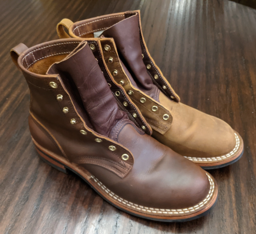

In [5]:
from fastdownload import download_url
dest = 'search1.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Enter Photo key to search:slippers


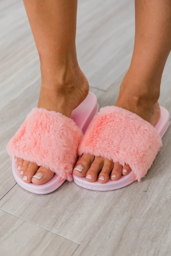

In [6]:
download_url(search_images(input('Enter Photo key to search:'), max_images=1)[0], 'search2.jpg', show_progress=False)
Image.open('search2.jpg').to_thumb(256,256)

Enter Photo key to search:flip flop


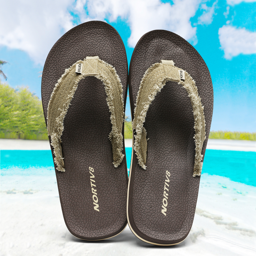

In [7]:
download_url(search_images(input('Enter Photo key to search:'), max_images=1)[0], 'search3.jpg', show_progress=False)
Image.open('search3.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab 200 examples of each of "bird" and "forest" photos, and save each group of photos to a different folder:

## Step 2: Train our model

In [15]:
# Modify Below list with list of classes to build a model
searches = input("Enter comma seperated classification types:")

# ----------------------------------------- #
searches = tuple([x.strip() for x in searches.split(',')])
searches = sorted(searches)
values = [i for i in range(0,len(searches))]

class_dict = dict(zip(searches,values))

path = Path('what_is_it')

# Below line will clean the path
if(os.path.exists(path)): shutil.rmtree(path)

for o in searches:
    dest = (path/'original'/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/'original'/o, max_size=400, dest=path/o)

Enter comma seperated classification types:snow boot, summer boot, boat shoes


Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [16]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

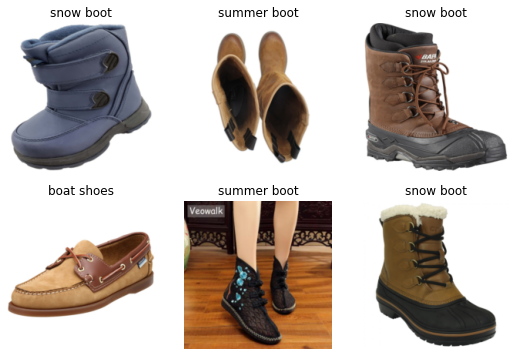

In [17]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [18]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.148804,0.159647,0.055556,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.201599,0.056235,0.034188,00:26
1,0.123765,0.016870,0.008547,00:28
2,0.074083,0.012519,0.004274,00:26


"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about a new photo

Enter Search Key:green shoes with long top


This is a: summer boot.
Probability it's a summer boot: 99.63%


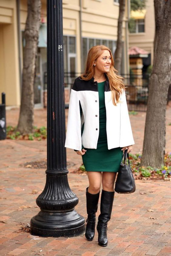

In [19]:
# Search new photo and let model classify

search_key = input('Enter Search Key:')

dest = 'new_photo.jpg'
download_url(search_images(search_key, max_images=1)[0], dest, show_progress=False)

classication,_,probs = learn.predict(PILImage.create(dest))
print(f"This is a: {classication}.")
print(f"Probability it's a {classication}: {probs[class_dict[classication]]*100:.2f}%")

im = Image.open(dest)
im.to_thumb(256,256)

In [22]:
# Or upload you own photo and let model classify

def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())


file_name = upload_files()

Saving 00_s_ODg1WDE2MDA__z_oVcAAOSwGvhT5BMF___12.jpeg to 00_s_ODg1WDE2MDA__z_oVcAAOSwGvhT5BMF___12 (1).jpeg


This is a: boat shoes.
Probability it's a boat shoes: 100.00%


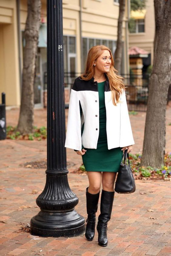

In [25]:
classication,_,probs = learn.predict(PILImage.create(file_name[0]))
print(f"This is a: {classication}.")
print(f"Probability it's a {classication}: {probs[class_dict[classication]]*100:.2f}%")

im = Image.open(dest)
im.to_thumb(256,256)

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.